<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#1.-Feed-Forward-Fully-Connected-Neural-Network-Set-up-(Feedforward)" data-toc-modified-id="1.-Feed-Forward-Fully-Connected-Neural-Network-Set-up-(Feedforward)-1">1. Feed-Forward Fully Connected Neural Network Set-up (Feedforward)</a></span></li><li><span><a href="#2.-Jacobian-Matrixes-Set-up-(Backpropagation)" data-toc-modified-id="2.-Jacobian-Matrixes-Set-up-(Backpropagation)-2">2. Jacobian Matrixes Set-up (Backpropagation)</a></span></li><li><span><a href="#3.-Mini-batch-Algorithm-Set-up" data-toc-modified-id="3.-Mini-batch-Algorithm-Set-up-3">3. Mini-batch Algorithm Set-up</a></span></li><li><span><a href="#4.-Unemployment-Rate-Import-and-Preprocessing" data-toc-modified-id="4.-Unemployment-Rate-Import-and-Preprocessing-4">4. Unemployment Rate Import and Preprocessing</a></span></li><li><span><a href="#5.-Optimization-Algorithms:-BGD,-SGD,-MBSGD" data-toc-modified-id="5.-Optimization-Algorithms:-BGD,-SGD,-MBSGD-5">5. Optimization Algorithms: BGD, SGD, MBSGD</a></span><ul class="toc-item"><li><span><a href="#a.-(Batch)-Gradient-Descent" data-toc-modified-id="a.-(Batch)-Gradient-Descent-5.1">a. (Batch) Gradient Descent</a></span></li><li><span><a href="#b.-Stochastic-Gradient-Descent" data-toc-modified-id="b.-Stochastic-Gradient-Descent-5.2">b. Stochastic Gradient Descent</a></span></li><li><span><a href="#c.-Mini-batch-Stochastic-Gradient-Descent" data-toc-modified-id="c.-Mini-batch-Stochastic-Gradient-Descent-5.3">c. Mini-batch Stochastic Gradient Descent</a></span></li><li><span><a href="#d.-Comparison-among-the-Optimization-Algorithms" data-toc-modified-id="d.-Comparison-among-the-Optimization-Algorithms-5.4">d. Comparison among the Optimization Algorithms</a></span></li></ul></li><li><span><a href="#6.-Hyperparameters-Tunning" data-toc-modified-id="6.-Hyperparameters-Tunning-6">6. Hyperparameters Tunning</a></span></li><li><span><a href="#7.-Model-Prediction-and-Evaluation" data-toc-modified-id="7.-Model-Prediction-and-Evaluation-7">7. Model Prediction and Evaluation</a></span></li></ul></div>

In [3]:
import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt

# the original economic paper can be found at:
# title: Macroeconomic Indicator Forecasting with Deep Neural Networks
# https://www.kansascityfed.org/documents/4065/pdf-Macroeconomic%20Indicator%20Forecasting%20with%20Deep%20Neural%20Networks.pdf

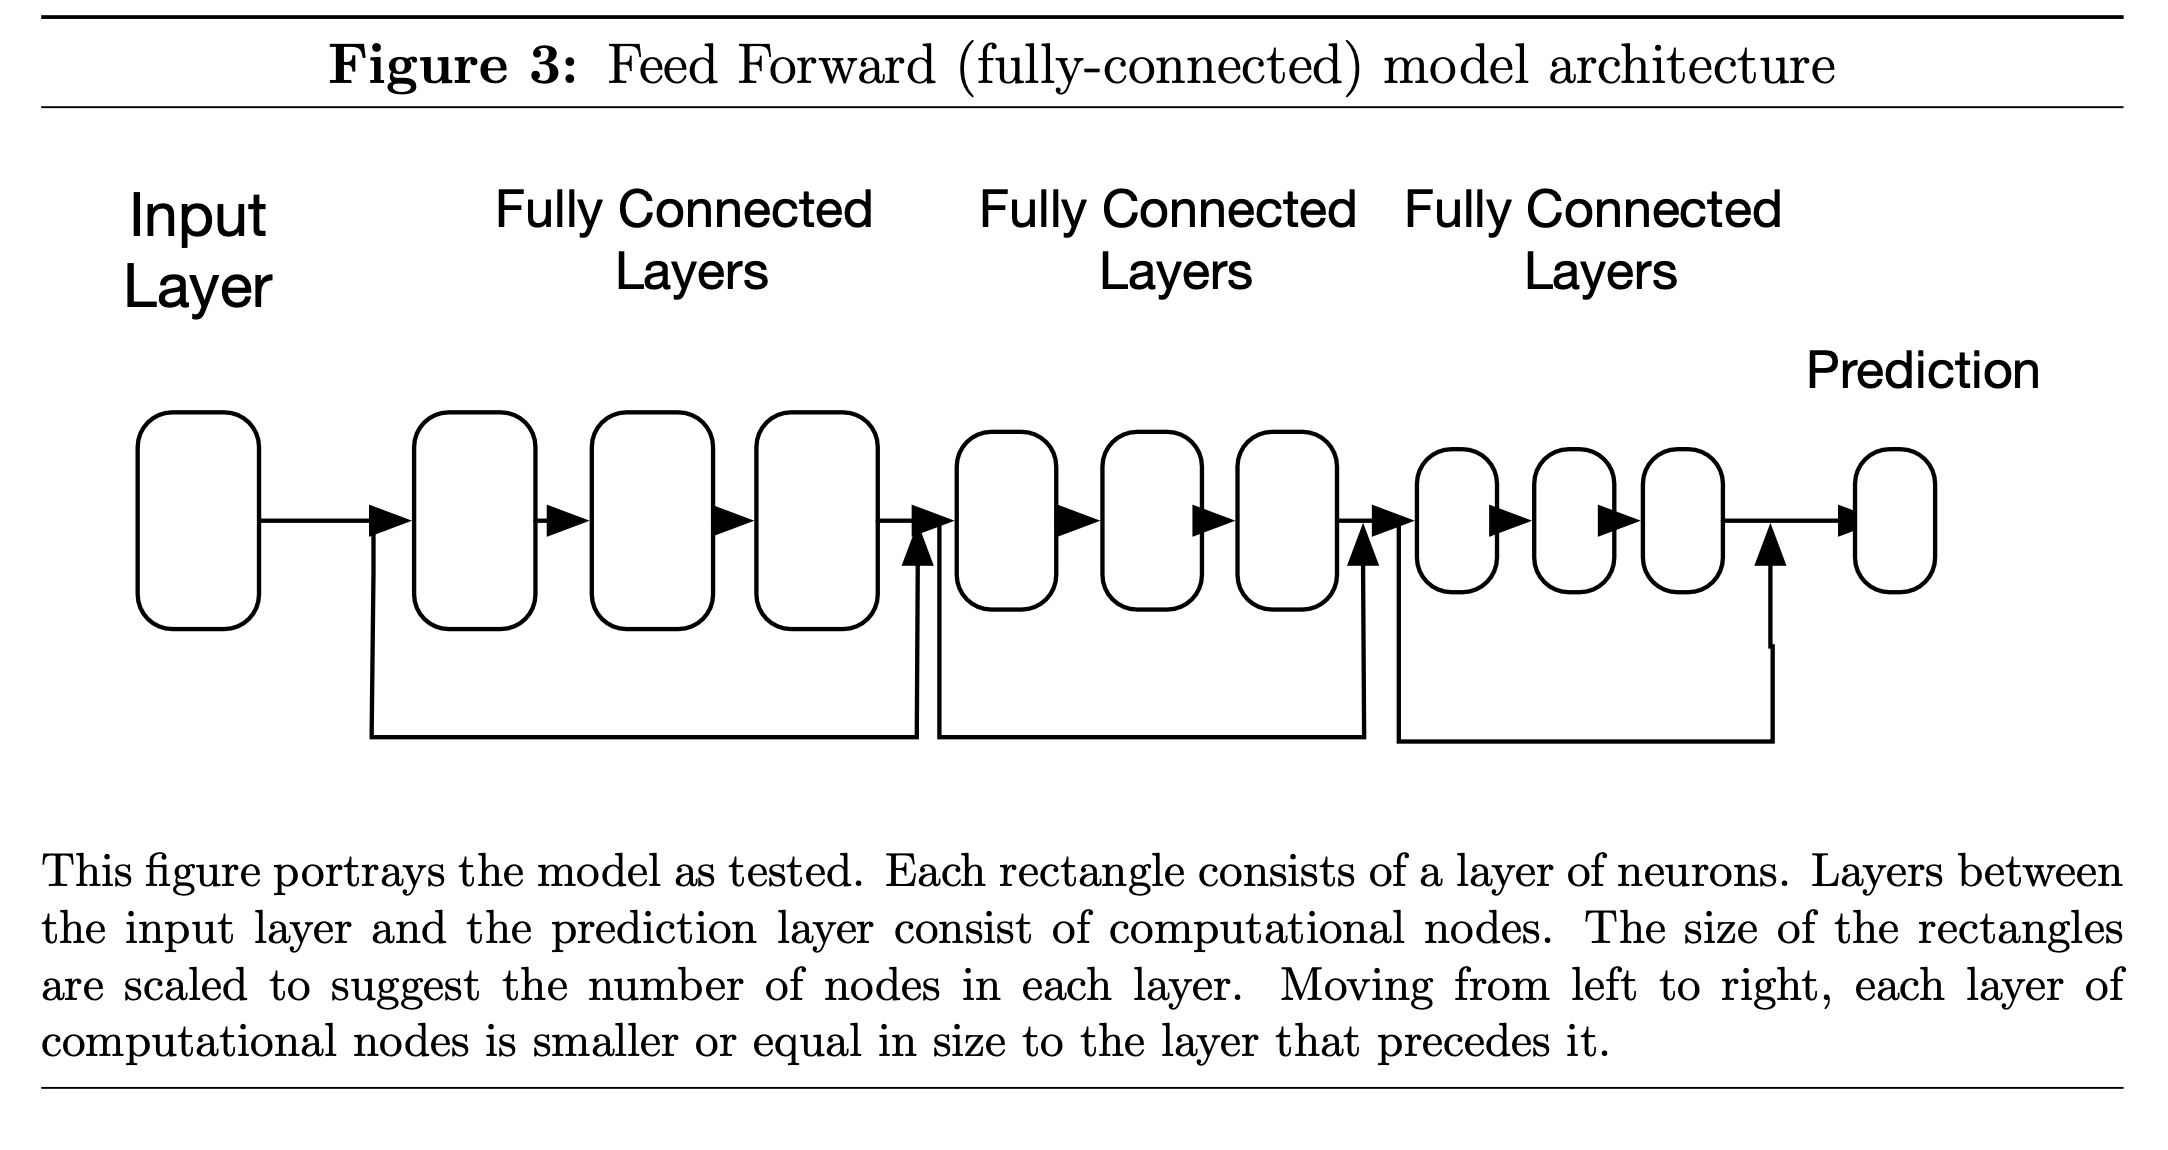

In [4]:
# quote the architecture from paper
from IPython.display import Image
Image(filename = './FFNN_Architecture.png', width=800)

# 1. Feed-Forward Fully Connected Neural Network Set-up (Feedforward)

In [5]:
# this function defines sigmoid activation function: f(x) = 1 / (1 + e^(-x))
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

# this function defines the derivative of sigmoid function
def deriv_sigmoid(x):
    fx = sigmoid(x)
    return fx * (1 - fx)

# this function defines the loss function, Mean Squared Error (MSE)
def MSE(y_true, y_prediction):
    return ((y_true - y_prediction) ** 2).mean()

In [6]:
# this function initialises the network with the structure of 5 layers
# n1 is the number of neurons at the 1st hidden layer
# n2 is the number of neurons at the 2nd hidden layer
# n3 is the number of neurons at the 3rd hidden layer

def parameters_reset (n1, n2, n3) :
    # show that we are changing the global variables
    global W1, W2, W3, W4, b1, b2, b3, b4
    # to keep the initial parameters the same
    np.random.seed(42)
    
    W1 = np.random.randn(n1, 36) / 2
    W2 = np.random.randn(n2, n1) / 2
    W3 = np.random.randn(n3, n2) / 2
    W4 = np.random.randn(1 , n3) / 2
    
    b1 = np.random.randn(n1, 1 ) / 2
    b2 = np.random.randn(n2, 1 ) / 2
    b3 = np.random.randn(n3, 1 ) / 2
    b4 = np.random.randn(1 , 1 ) / 2

In [7]:
# This function realizes the Feedforward
def network_function (a0,W1,W2,W3,W4,b1,b2,b3,b4) :
    s1 = W1 @ a0 + b1
    a1 = sigmoid(s1) 
    s2 = W2 @ a1 + b2
    a2 = sigmoid(s2)
    s3 = W3 @ a2 + b3
    a3 = sigmoid(s3)
    s4 = W4 @ a3 + b4
    # since this is not a classification problem, we do not put activation function on the output layer
    return a0, s1, a1, s2, a2, s3, a3, s4

# 2. Jacobian Matrixes Set-up (Backpropagation)

In [8]:
# Jacobian for the weights of the output layer
def J_W4 (x, y) :
    # d c /s4 = - 2 * (y - s4) 
    J = - 2 * (y - s4) 
    # d s4/w4 = a3
    J = J @ a3.T / x.shape[1]
    return J

# Jacobian for the bias of the output layer
def J_b4 (x, y) :
    
    # d c /s4 = - 2 * (y - s4) 
    J = - 2 * (y - s4)
    # d s4/b4 = 1
    J = np.sum(J, axis=1, keepdims=True) / x.shape[1]
    return J

In [9]:
# Jacobian for the weights of the 3rd hidden layer
def J_W3 (x, y) :
    # d c /s4 = - 2 * (y - s4) 
    J = - 2 * (y - s4)
    # d s4/a3 = W4
    J = (J.T @ W4).T
    # d a3/s3 = s'(s3)
    J = J * deriv_sigmoid(s3)
    # d s3/W3 = a2
    J = J @ a2.T / x.shape[1]
    return J

# Jacobian for the bias of the 3rd hidden layer
def J_b3 (x, y) :
    # d c /s4 = - 2 * (y - s4) 
    J = - 2 * (y - s4)
    # d s4/a3 = W4
    J = (J.T @ W4).T
    # d a3/s3 = s'(s3)
    J = J * deriv_sigmoid(s3)   
    # d s3/b3 = 1
    J = np.sum(J, axis=1, keepdims=True) / x.shape[1]
    return J

In [10]:
# Jacobian for the weights of the 2nd hidden layer
def J_W2 (x, y) :
    # d c /s4 = - 2 * (y - s4) 
    J = - 2 * (y - s4)
    # d s4/a3 = W4
    J = (J.T @ W4).T
    # d a3/s3 = s'(s3)
    J = J * deriv_sigmoid(s3)
    # d s3/a2 = W3
    J = (J.T @ W3).T    
    # d a2/s2 = s'(s2)
    J = J * deriv_sigmoid(s2)  
    # d s2/W2 = a1
    J = J @ a1.T / x.shape[1]
    return J

# Jacobian for the biases of the 2nd hidden layer
def J_b2 (x, y) :
    # d c /s4 = - 2 * (y - s4) 
    J = - 2 * (y - s4)
    # d s4/a3 = W4
    J = (J.T @ W4).T
    # d a3/s3 = s'(s3)
    J = J * deriv_sigmoid(s3)
    # d s3/a2 = W3
    J = (J.T @ W3).T    
    # d a2/s2 = s'(s2)
    J = J * deriv_sigmoid(s2)  
    # d s2/b2 = 1
    J = np.sum(J, axis=1, keepdims=True) / x.shape[1]
    return J

In [11]:
# Jacobian for the weights of the 1st hidden layer
def J_W1 (x, y) :
    # d c /s4 = - 2 * (y - s4) 
    J = - 2 * (y - s4)
    # d s4/a3 = W4
    J = (J.T @ W4).T
    # d a3/s3 = s'(s3)
    J = J * deriv_sigmoid(s3)
    # d s3/a2 = W3
    J = (J.T @ W3).T    
    # d a2/s2 = s'(s2)
    J = J * deriv_sigmoid(s2)  
    # d s2/a1 = W2
    J = (J.T @ W2).T   
    # d a1/s1 = s'(s1)
    J = J * deriv_sigmoid(s1)   
    # d s1/W1 = a0
    J = J @ a0.T / x.shape[1]
    return J    

# Jacobian for the biases of the 1st hidden layer
def J_b1 (x, y) :
    # d c /s4 = - 2 * (y - s4) 
    J = - 2 * (y - s4)
    # d s4/a3 = W4
    J = (J.T @ W4).T
    # d a3/s3 = s'(s3)
    J = J * deriv_sigmoid(s3)
    # d s3/a2 = W3
    J = (J.T @ W3).T    
    # d a2/s2 = s'(s2)
    J = J * deriv_sigmoid(s2)  
    # d s2/a1 = W2
    J = (J.T @ W2).T   
    # d a1/s1 = s'(s1)
    J = J * deriv_sigmoid(s1)   
    # d s1/b1 = 1
    J = np.sum(J, axis=1, keepdims=True) / x.shape[1]
    return J

# 3. Mini-batch Algorithm Set-up

In [12]:
# define the function that randomly sorts the data batches (size > 1)
# note: the data strcuture of X and y should be DataFrame
def batches(X, y, size, seed):
    # 1.fix this random seed at this moment, and this will be changed for each iteration
    np.random.seed(seed)
    # 2.number of total instances
    num_instances = X.shape[0]
    # 3.list initialized
    batches_full  = []
    # 4.shuffle X and y 
    shuf_order = list(np.random.permutation(num_instances))
    shuf_X     = X.iloc[shuf_order,:]
    shuf_y     = y.iloc[shuf_order,:]
    # 5.get the number of the batches could be reached
    num_batch  = math.floor(num_instances / size)    
    # 6.get the new sorted batches
    for k in range(num_batch):
        batches_X = shuf_X.iloc[k*size : (k+1)*size-1 ,:]
        batches_y = shuf_y.iloc[k*size : (k+1)*size-1 ,:]
        batches   = (batches_X, batches_y)
        batches_full.append(batches)
    # 7.get the last remaining batch
    if num_instances % size != 0:
        batches_X = shuf_X.iloc[size * num_batch:,:]
        batches_y = shuf_y.iloc[size * num_batch:,:]
        batches   = (batches_X, batches_y)
        batches_full.append(batches)
    return batches_full

# 4. Unemployment Rate Import and Preprocessing

In [13]:
# the dataset is the monthly unemployment rate (UNRATE) from 1963 to 2014, 
# provided by the US Bureau of Labor and Statistics.
# it can be found at: https://fred.stlouisfed.org/series/UNRATE.

# 1.instance generation

# since the raw data is a 1-dimension data, for the purpose of
# getting 36 previous unrates and getting 1 current unrate as the output,
# we use sliding window (step = 1) to create the following dataframe
# 1 to 36 are the inputs, and UNRATE is the true value of the output.
unrate = pd.read_csv('./UNRATE.csv')

for i in range (36):
    unrate.loc[:,i+1] = unrate['UNRATE'].shift(36-i)
unrate =  unrate.iloc[36:,:].reset_index(drop=True) # loose 36 obs

# 2.training, validation, test set split

# generate the training set, validation set, and test set
# mian train set: 1966-1996, test set: 1997-2014
# every 12th observation in mian train set is in validation set, remaining is in training set

from datetime import datetime
unrate['DATE'] = unrate['DATE'].apply(lambda x: datetime.strptime(x,'%Y-%m-%d'))
# unrate['DATE'] = pd.to_datetime(unrate['DATE'], format='%Y-%m-%d')

df_train_main = unrate[unrate.DATE <= datetime.strptime('1996-12-01', '%Y-%m-%d')]
df_test       = unrate[unrate.DATE >  datetime.strptime('1996-12-01', '%Y-%m-%d')].reset_index(drop=True)
df_train      = df_train_main[df_train_main.DATE.dt.strftime('%m') != '12'].reset_index(drop=True)
df_validation = df_train_main[df_train_main.DATE.dt.strftime('%m') == '12'].reset_index(drop=True)

X  = np.array(unrate.iloc[:,2:].T)
y  = np.array(unrate[['UNRATE']].T)

unrate.shape, df_train.shape, df_validation.shape, df_test.shape

((588, 38), (341, 38), (31, 38), (216, 38))

# 5. Optimization Algorithms: BGD, SGD, MBSGD

## a. (Batch) Gradient Descent

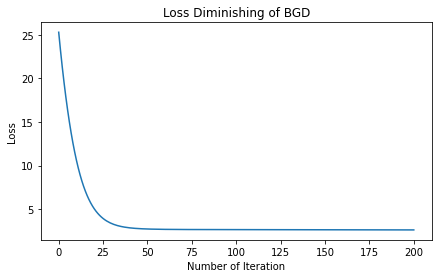

In [14]:
# 1.parameters setting
learn_rate      = 0.01
total_iteration = 200

# 2.parameters reset and feedforeward
parameters_reset (n1 = 4, n2 = 4, n3 = 4)
a0, s1, a1, s2, a2, s3, a3, s4 = network_function(X,W1,W2,W3,W4,b1,b2,b3,b4)

# 3.create a list to keep the loss
Los_GD          = []

# 4.keep the initial loss
Loss = MSE(y, s4)
Los_GD.append(Loss)
#print("Iteration %d loss: %.3f" % (0, Loss))

# 5.BGD algorithm
for iteration_number in range(1,total_iteration+1): 
    W1 -= learn_rate * J_W1 (X, y)
    W2 -= learn_rate * J_W2 (X, y)
    W3 -= learn_rate * J_W3 (X, y)
    W4 -= learn_rate * J_W4 (X, y)
    
    b1 -= learn_rate * J_b1 (X, y)
    b2 -= learn_rate * J_b2 (X, y)
    b3 -= learn_rate * J_b3 (X, y)
    b4 -= learn_rate * J_b4 (X, y)
    a0, s1, a1, s2, a2, s3, a3, s4 = network_function(X,W1,W2,W3,W4,b1,b2,b3,b4)
    
    Loss = MSE(y, s4)
    Los_GD.append(Loss)
    #print("Iteration %d loss: %.3f" % (iteration_number, Loss))

# 6.plot the diagram of iteration and lossfuntion
plt.figure(figsize= (7,4))
plt.title("Loss Diminishing of BGD")
plt.xlabel('Number of Iteration')
plt.ylabel('Loss')
plt.plot(range(201), Los_GD)

## b. Stochastic Gradient Descent

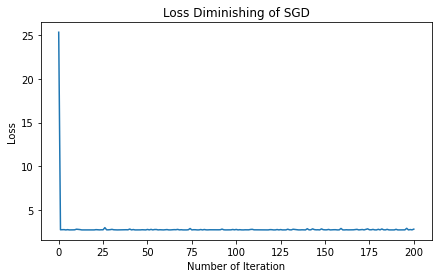

In [15]:
# 1.parameters setting
learn_rate      = 0.01
total_iteration = 200

# 2.parameters reset and feedforeward
parameters_reset (n1 = 4, n2 = 4, n3 = 4)
a0, s1, a1, s2, a2, s3, a3, s4 = network_function(X,W1,W2,W3,W4,b1,b2,b3,b4)

# 3.create a list to keep the loss
Los_SGD         = []

# 4.keep the initial loss
Loss = MSE(y, s4)
Los_SGD.append(Loss)
#print("Iteration %d loss: %.3f" % (0, Loss))

# 5.SGD algorithm
for iteration_number in range(1,total_iteration+1): 
    for i in list(np.random.permutation(X.shape[1])):
        # get the values of all the data points
        A0, S1, A1, S2, A2, S3, A3, S4 = network_function(X,W1,W2,W3,W4,b1,b2,b3,b4)
        # get the value for each data point
        a0 = A0.T[i].reshape(36,1)
        s1 = S1.T[i].reshape(4 ,1)
        a1 = A1.T[i].reshape(4 ,1)
        s2 = S2.T[i].reshape(4 ,1)
        a2 = A2.T[i].reshape(4 ,1)
        s3 = S3.T[i].reshape(4 ,1)
        a3 = A3.T[i].reshape(4 ,1)
        s4 = S4.T[i].reshape(1 ,1)
        # update parameters based on single data point
        W1 -= learn_rate * J_W1 (a0, y[0][i])
        W2 -= learn_rate * J_W2 (a0, y[0][i])
        W3 -= learn_rate * J_W3 (a0, y[0][i])
        W3 -= learn_rate * J_W4 (a0, y[0][i])
        b1 -= learn_rate * J_b1 (a0, y[0][i])
        b2 -= learn_rate * J_b2 (a0, y[0][i])
        b3 -= learn_rate * J_b3 (a0, y[0][i])
        b4 -= learn_rate * J_b4 (a0, y[0][i])
    # record the performance at the end of this iteration
    a0, s1, a1, s2, a2, s3, a3, s4 = network_function(X,W1,W2,W3,W4,b1,b2,b3,b4)
    Loss = MSE(y, s4)
    Los_SGD.append(Loss)
    #print("Iteration %d loss: %.3f" % (iteration_number, Loss))

# 6.plot the diagram of iteration and lossfuntion
plt.figure(figsize= (7,4))
plt.title("Loss Diminishing of SGD")
plt.xlabel('Number of Iteration')
plt.ylabel('Loss')
plt.plot(range(201), Los_SGD)

## c. Mini-batch Stochastic Gradient Descent

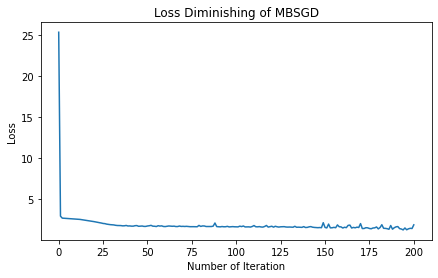

In [16]:
# 1.parameters setting
learn_rate      = 0.01
total_iteration = 200
batch_siz = 16
see = 0

# 2.parameters reset and feedforeward
parameters_reset (n1 = 4, n2 = 4, n3 = 4)
a0, s1, a1, s2, a2, s3, a3, s4 = network_function(X,W1,W2,W3,W4,b1,b2,b3,b4)

# 3.create a list to keep the loss
Los_MBSGD       = []

# 4.keep the initial loss
Loss = MSE(y, s4)
Los_MBSGD.append(Loss)
#print("Iteration %d loss: %.3f" % (0, Loss))

# 5.reset dataset for MINIBATCH algorithm
df_X  = unrate.iloc[:,2:]
df_y  = unrate[['UNRATE']]

# 6.MBSGD algorithm
for iteration_number in range (1,total_iteration+1): 
    # split data into batches
    for Batch in batches (df_X, df_y, size = batch_siz, seed = see):
        # get data batches
        (Batch_X, Batch_y) = Batch
        # transform datches into array for later use
        Batch_X = np.array(Batch_X).T
        Batch_y = np.array(Batch_y).T
        # parameters update
        a0, s1, a1, s2, a2, s3, a3, s4 = network_function(Batch_X,W1,W2,W3,W4,b1,b2,b3,b4)
        W1 -= learn_rate * J_W1 (a0, Batch_y)
        W2 -= learn_rate * J_W2 (a0, Batch_y)
        W3 -= learn_rate * J_W3 (a0, Batch_y)
        W4 -= learn_rate * J_W4 (a0, Batch_y)
        b1 -= learn_rate * J_b1 (a0, Batch_y)
        b2 -= learn_rate * J_b2 (a0, Batch_y)
        b3 -= learn_rate * J_b3 (a0, Batch_y)
        b4 -= learn_rate * J_b4 (a0, Batch_y)
    # at the end of each iteration, we keep the loss for the all the instances
    see += 1
    a0, s1, a1, s2, a2, s3, a3, s4 = network_function(X,W1,W2,W3,W4,b1,b2,b3,b4)
    Loss = MSE(y, s4)
    Los_MBSGD.append(Loss)
    #print("Iteration %d loss: %.3f" % (iteration_number, Loss))

# 7.plot the diagram of iteration and lossfuntion
plt.figure(figsize= (7,4))
plt.title("Loss Diminishing of MBSGD")
plt.xlabel('Number of Iteration')
plt.ylabel('Loss')
plt.plot(range(201), Los_MBSGD)

## d. Comparison among the Optimization Algorithms

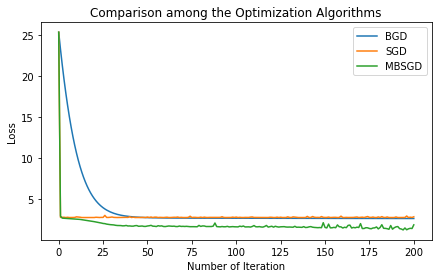

In [17]:
# 1.plot the whole training process
plt.figure(figsize= (7,4))
plt.title("Comparison among the Optimization Algorithms")
plt.xlabel('Number of Iteration')
plt.ylabel('Loss')
plt.plot(range(201), Los_GD)
plt.plot(range(201), Los_SGD)
plt.plot(range(201), Los_MBSGD)
plt.legend(['BGD', 'SGD', 'MBSGD'], loc='upper right')
plt.show()

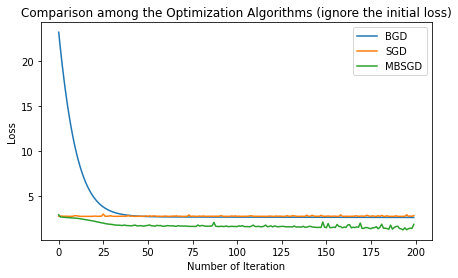

In [18]:
# 2.to see the fluctuations, we ignore the initial value
plt.figure(figsize= (7,4))
plt.title("Comparison among the Optimization Algorithms (ignore the initial loss)")
plt.xlabel('Number of Iteration')
plt.ylabel('Loss')
plt.plot(range(200), Los_GD[1:])
plt.plot(range(200), Los_SGD[1:])
plt.plot(range(200), Los_MBSGD[1:])
plt.legend(['BGD', 'SGD', 'MBSGD'], loc='upper right')
plt.show()

# 6. Hyperparameters Tunning

In [19]:
# 1. release the random seed in parameter initialization,
# and hold the optimization method (MBSGD) as a function

def parameters_reset_random (n1, n2, n3, rs) :
    # show that we are changing the global variables
    global W1, W2, W3, W4, b1, b2, b3, b4
    # to keep the initial parameters the same
    np.random.seed(rs)
    
    W1 = np.random.randn(n1, 36) / 2
    W2 = np.random.randn(n2, n1) / 2
    W3 = np.random.randn(n3, n2) / 2
    W4 = np.random.randn(1 , n3) / 2
    
    b1 = np.random.randn(n1, 1 ) / 2
    b2 = np.random.randn(n2, 1 ) / 2
    b3 = np.random.randn(n3, 1 ) / 2
    b4 = np.random.randn(1 , 1 ) / 2
    
def hyperparameter_tunning_MBSGD_random (n, rs) :
    global W1, W2, W3, W4, b1, b2, b3, b4, a0, s1, a1, s2, a2, s3, a3, s4
    # 1.parameters
    learn_rate      = 0.01
    total_iteration = 100
    batch_siz       = 8
    see             = 0
    # 2.dataset import  -------------------train the model with the training set
    X_train  = np.array(df_train.iloc[:,2:].T)
    y_train  = np.array(df_train[['UNRATE']].T)
    # 3.parameters reset and feedforeward
    parameters_reset_random (n, n, n, rs)
    a0, s1, a1, s2, a2, s3, a3, s4 = network_function (X_train,W1,W2,W3,W4,b1,b2,b3,b4)
    # 4.reset dataset for MINIBATCH algorithm
    df_X_train  = df_train.iloc[:,2:]
    df_y_train  = df_train[['UNRATE']]
    # 5.MBSGD algorithm
    for iteration_number in range (1,total_iteration+1): 
        for Batch in batches (df_X_train, df_y_train, size = batch_siz, seed = see):
            # get data batches
            (Batch_X, Batch_y) = Batch
            # transform datches into array for later use
            Batch_X = np.array(Batch_X).T
            Batch_y = np.array(Batch_y).T
            # parameters update
            a0, s1, a1, s2, a2, s3, a3, s4 = network_function(Batch_X,W1,W2,W3,W4,b1,b2,b3,b4)
            W1 -= learn_rate * J_W1 (a0, Batch_y)
            W2 -= learn_rate * J_W2 (a0, Batch_y)
            W3 -= learn_rate * J_W3 (a0, Batch_y)
            W4 -= learn_rate * J_W4 (a0, Batch_y)
            b1 -= learn_rate * J_b1 (a0, Batch_y)
            b2 -= learn_rate * J_b2 (a0, Batch_y)
            b3 -= learn_rate * J_b3 (a0, Batch_y)
            b4 -= learn_rate * J_b4 (a0, Batch_y)
        # keep the random for next shuffle
        see += 1
    # 6.have got the best parameters for the training set, now we evluate on the validation set
    # -------------------------------evaluate the model on the validation set
    X_validation = np.array(df_validation.iloc[:,2:].T)
    y_validation = np.array(df_validation[['UNRATE']].T)
    a0, s1, a1, s2, a2, s3, a3, y_predicted = network_function(X_validation,W1,W2,W3,W4,b1,b2,b3,b4)
    # 7.output the MSE at the validation set          
    return MSE(y_validation, y_predicted)

In [20]:
# 2. set up different structure candidates and pick the best one (the smallest MSE on validation set)
# here we only test the model with 3 hidden layers, where the numbers of neurons at each layer are the same
structure_candidats = np.arange(4,61,4)

for i in range(len(np.arange(4,61,4))):
    MSE_record = hyperparameter_tunning_MBSGD_random (structure_candidats[i], i)
    print('the structure of {}-{}-{} gives {:.2f} MSE at the validation set'.format(
        structure_candidats[i],structure_candidats[i],structure_candidats[i],MSE_record))

the structure of 4-4-4 gives 2.48 MSE at the validation set
the structure of 8-8-8 gives 1.49 MSE at the validation set
the structure of 12-12-12 gives 1.45 MSE at the validation set
the structure of 16-16-16 gives 1.47 MSE at the validation set
the structure of 20-20-20 gives 1.39 MSE at the validation set
the structure of 24-24-24 gives 1.40 MSE at the validation set
the structure of 28-28-28 gives 1.21 MSE at the validation set
the structure of 32-32-32 gives 1.02 MSE at the validation set
the structure of 36-36-36 gives 0.83 MSE at the validation set
the structure of 40-40-40 gives 1.15 MSE at the validation set
the structure of 44-44-44 gives 2.22 MSE at the validation set
the structure of 48-48-48 gives 1.46 MSE at the validation set
the structure of 52-52-52 gives 2.38 MSE at the validation set
the structure of 56-56-56 gives 1.49 MSE at the validation set
the structure of 60-60-60 gives 0.98 MSE at the validation set


# 7. Model Prediction and Evaluation

In [21]:
# 1.train the model on the training set (get best weights and biases)

# From the last section, we have picked the best strcture of '36-36-36'
# now we can train the whole df_train_main with this architecture 

def model_training () :
    global W1, W2, W3, W4, b1, b2, b3, b4, a0, s1, a1, s2, a2, s3, a3, s4
    # 1.parameters
    learn_rate      = 0.01
    total_iteration = 200
    batch_siz       = 16
    see             = 0
    # 2.dataset import-------------------train the model with the training set + validation set
    X_train_main  = np.array(df_train_main.iloc[:,2:].T)
    y_train_main  = np.array(df_train_main[['UNRATE']].T)
    # 3.parameters reset and feedforeward
    parameters_reset_random (36, 36, 36, rs = 42)
    a0, s1, a1, s2, a2, s3, a3, s4 = network_function (X_train_main,W1,W2,W3,W4,b1,b2,b3,b4)
    # 4.reset dataset for MINIBATCH algorithm
    df_X  = df_train_main.iloc[:,2:]
    df_y  = df_train_main[['UNRATE']]
    # 5.MBSGD algorithm
    for iteration_number in range (1,total_iteration+1): 
        for Batch in batches (df_X, df_y, size = batch_siz, seed = see):
            # get data batches
            (Batch_X, Batch_y) = Batch
            # transform datches into array for later use
            Batch_X = np.array(Batch_X).T
            Batch_y = np.array(Batch_y).T
            # parameters update
            a0, s1, a1, s2, a2, s3, a3, s4 = network_function(Batch_X,W1,W2,W3,W4,b1,b2,b3,b4)
            W1 -= learn_rate * J_W1 (a0, Batch_y)
            W2 -= learn_rate * J_W2 (a0, Batch_y)
            W3 -= learn_rate * J_W3 (a0, Batch_y)
            W4 -= learn_rate * J_W4 (a0, Batch_y)
            b1 -= learn_rate * J_b1 (a0, Batch_y)
            b2 -= learn_rate * J_b2 (a0, Batch_y)
            b3 -= learn_rate * J_b3 (a0, Batch_y)
            b4 -= learn_rate * J_b4 (a0, Batch_y)
        # keep the random for next shuffle
        see += 1
    # 6.have got the best parameters for the training set, now we output them
    a0, s1, a1, s2, a2, s3, a3, s4 = network_function(X,W1,W2,W3,W4,b1,b2,b3,b4)       
    return W1,W2,W3,W4,b1,b2,b3,b4,MSE(X,s4)
# keep the parameters after training the model on the training set
W1_best, W2_best, W3_best, W4_best, b1_best, b2_best, b3_best, b4_best, MSE_on_training_set = model_training () 
print('the structure of 36-36-36 gives {:.2f} MSE at the whole training set, and we have recorded all the parameters'
      .format(MSE_on_training_set))

the structure of 36-36-36 gives 2.81 MSE at the whole training set, and we have recorded all the parameters


In [22]:
# 2. predict on the test set using the trained model and evluate the MSE

X_test = np.array(df_test.iloc[:,2:].T)
y_test = np.array(df_test[['UNRATE']].T)

def model_prediction () :
    global W1_best, W2_best, W3_best, W4_best, b1_best, b2_best, b3_best, b4_best
    a0, s1, a1, s2, a2, s3, a3, y_predicted_on_test = network_function (X_test,
                                                               W1_best, W2_best, W3_best, W4_best, 
                                                               b1_best, b2_best, b3_best, b4_best)
    return MSE(y_test, y_predicted_on_test)
print('the structure of 36-36-36 gives {:.2f} MSE at the test set'.format(model_prediction()))

the structure of 36-36-36 gives 2.07 MSE at the test set
